# STQD6324-Assignment 2-P149793

In [1]:
from pyhive import hive
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings('ignore')

# 1.Delay Patterns

In [2]:
conn = hive.Connection(host="127.0.0.1",
                       port=10000,
                       username="maria_dev",
                       database="default")
query1 = """
SELECT 
    year, month, dayofmonth, dayofweek,
    crsdeptime, arrdelay, cancelled, diverted
FROM airline_2006
WHERE year=2006
"""
raw_df = pd.read_sql(query1, conn)
conn.close()
raw_df.head()

,year,month,dayofmonth,dayofweek,crsdeptime,arrdelay,cancelled,diverted
0,2006,1,11,3,745,6.0,0,0
1,2006,1,11,3,1053,-5.0,0,0
2,2006,1,11,3,1915,-23.0,0,0
3,2006,1,11,3,1755,-8.0,0,0
4,2006,1,11,3,832,0.0,0,0


In [3]:
processed_df = raw_df[
    (raw_df['cancelled'] == 0) & 
    (raw_df['diverted'] == 0) &
    (raw_df['arrdelay'].notnull())
].copy()

In [4]:
processed_df['dephour'] = np.floor(
    pd.to_numeric(processed_df['crsdeptime'], errors='coerce') / 100
).clip(0,23).astype(int)

In [5]:
processed_df.head()

,year,month,dayofmonth,dayofweek,crsdeptime,arrdelay,cancelled,diverted,dephour
0,2006,1,11,3,745,6.0,0,0,7
1,2006,1,11,3,1053,-5.0,0,0,10
2,2006,1,11,3,1915,-23.0,0,0,19
3,2006,1,11,3,1755,-8.0,0,0,17
4,2006,1,11,3,832,0.0,0,0,8


In [6]:
bins = [0, 5, 12, 17, 21, 24]
labels = ['Late Night', 'Morning', 'Afternoon', 'Evening', 'Night']
processed_df['timeofday'] = pd.cut(
    processed_df['dephour'],
    bins=bins,
    labels=labels,
    right=False
)

In [7]:
season_map = {
    1: 'Winter', 2: 'Winter', 3: 'Spring',
    4: 'Spring', 5: 'Spring', 6: 'Summer',
    7: 'Summer', 8: 'Summer', 9: 'Fall',
    10: 'Fall', 11: 'Fall', 12: 'Winter'
}
processed_df['season'] = processed_df['month'].map(season_map)


## Average Delay by Time of Day

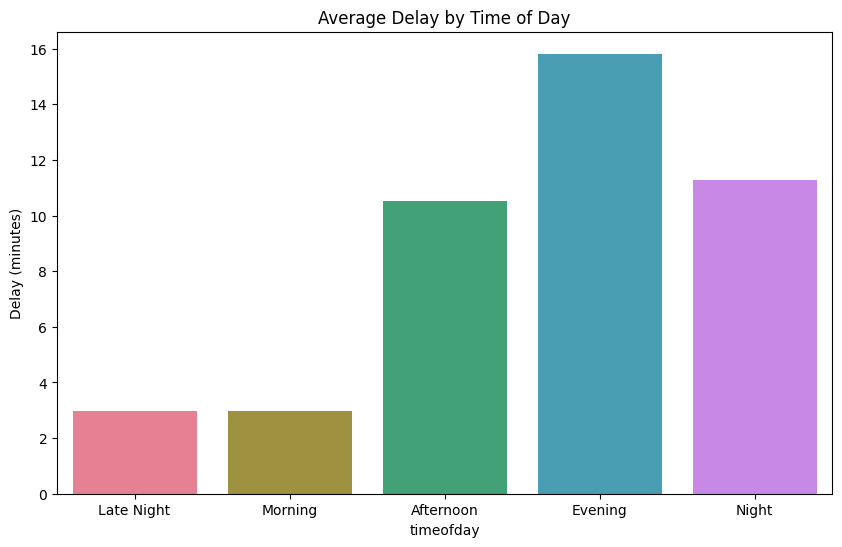

In [8]:
time_analysis = processed_df.groupby('timeofday', observed=True)['arrdelay'].agg(
    ['mean', 'count']
).reindex(labels)

#Visualization
plt.figure(figsize=(10,6))
sns.barplot(
    x=time_analysis.index,
    y=time_analysis['mean'],
    order=labels,
    palette=sns.color_palette("husl", n_colors=len(labels))
)

plt.title('Average Delay by Time of Day')
plt.ylabel('Delay (minutes)')
plt.show()

## Weekly On-time Performance

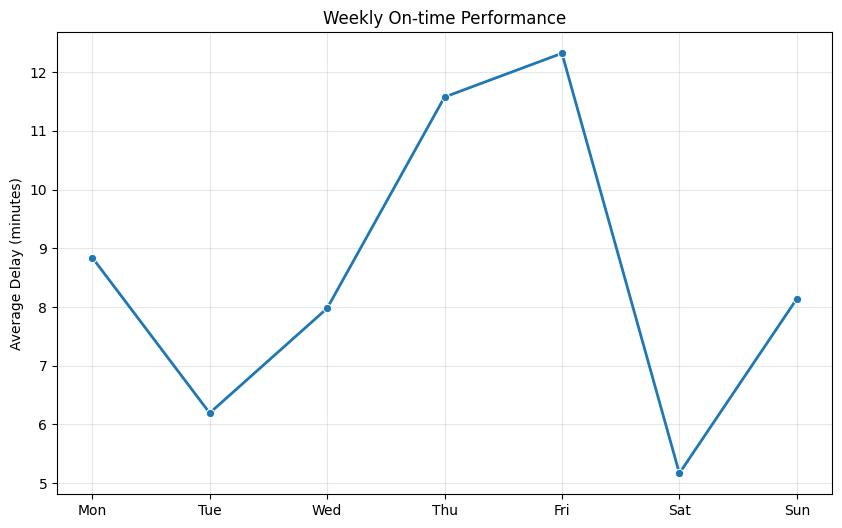

In [9]:
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekly_analysis = processed_df.groupby('dayofweek')['arrdelay'].agg(
    ['mean', 'count']
).reindex(range(1,8))
weekly_analysis.index = day_names

#Visualization
plt.figure(figsize=(10,6))
sns.lineplot(data=weekly_analysis['mean'], marker='o', linewidth=2)
plt.title('Weekly On-time Performance')
plt.ylabel('Average Delay (minutes)')
plt.xticks(range(7), day_names)
plt.grid(True, alpha=0.3)
plt.show()

## Seasonal Delay Patterns

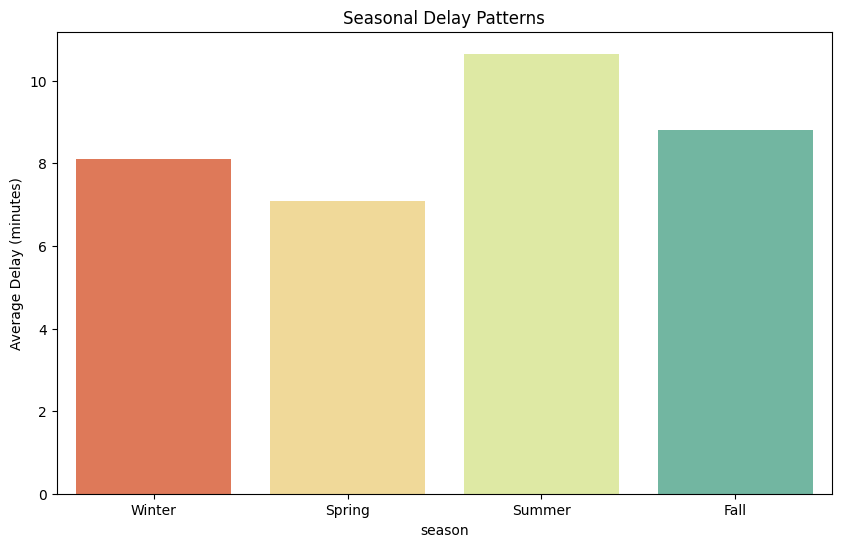

In [10]:
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
seasonal_analysis = processed_df.groupby('season', observed=True)['arrdelay'].agg(
    ['mean', 'count']
).reindex(season_order)

#Visualization
plt.figure(figsize=(10,6))
sns.barplot(
    x=seasonal_analysis.index,
    y=seasonal_analysis['mean'],
    order=season_order,
    palette=sns.color_palette("Spectral", n_colors=4)
)

plt.title('Seasonal Delay Patterns')
plt.ylabel('Average Delay (minutes)')
plt.show()

## Analysis Summary

In [11]:
print("\nTime period analysis results:")
print(time_analysis)
print("\nWeekly analysis results:")
print(weekly_analysis)
print("\nSeasonal analysis results:")
print(seasonal_analysis)


Time period analysis results:
                 mean    count
timeofday                     
Late Night   2.969309    15705
Morning      2.983879  2843841
Afternoon   10.521789  2206048
Evening     15.818038  1587918
Night       11.279979   350290

Weekly analysis results:
          mean    count
Mon   8.842539  1027988
Tue   6.195163  1012483
Wed   7.977179  1022327
Thu  11.575170  1028443
Fri  12.320714  1032497
Sat   5.169126   886411
Sun   8.139275   993653

Seasonal analysis results:
             mean    count
season                    
Winter   8.105541  1674046
Spring   7.086246  1768922
Summer  10.655150  1812428
Fall     8.806385  1748406


# 2.Delay Factors

In [12]:
conn = hive.Connection(host="127.0.0.1",
                       port=10000,
                       username="maria_dev",
                       database="default")
query2 = """
SELECT 
    CarrierDelay,
    WeatherDelay,
    NASDelay,
    SecurityDelay,
    LateAircraftDelay
FROM airline_2006
WHERE Year=2006 
  AND Cancelled=0 
  AND Diverted=0
  AND (ArrDelay > 0 OR DepDelay > 0)
"""
delay_df = pd.read_sql(query2, conn)
conn.close()
delay_df.head()

,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,20,0,0
3,0,0,0,0,0
4,0,0,0,0,0


## Analysis of Flight Delay Factors

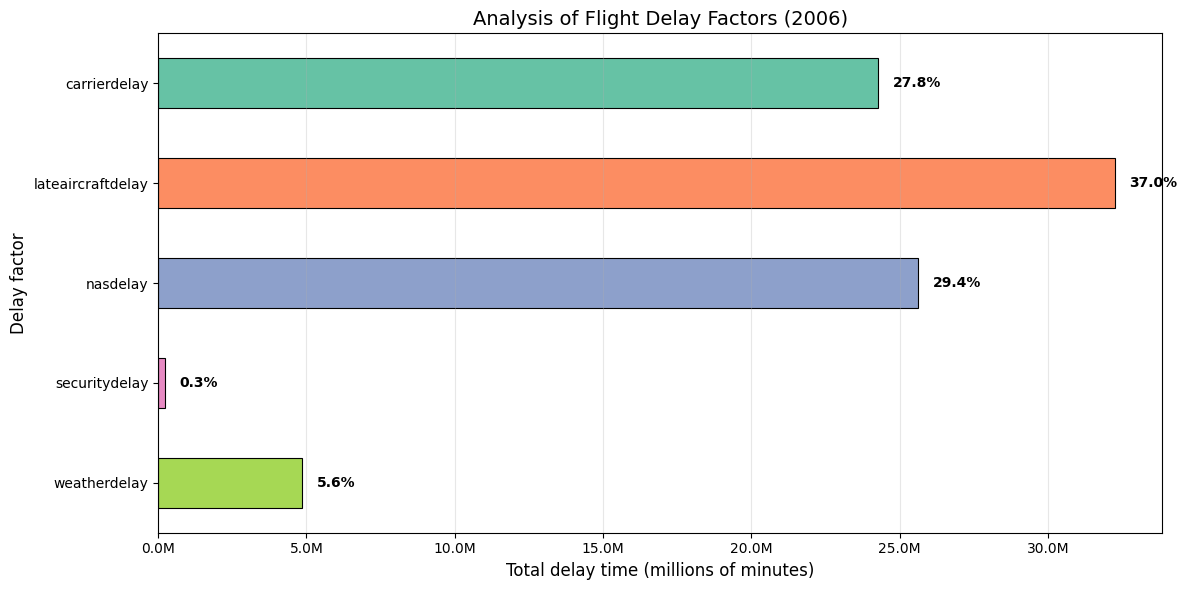

In [13]:
delay_df = delay_df.fillna(0).astype(int)
#Calculate the total delay time of each factor
delay_sum = delay_df.sum().sort_values(ascending=False)
total_delay = delay_sum.sum()
delay_pct = (delay_sum / total_delay * 100).round(1)

result = pd.DataFrame({
    'Total delay time (minutes)': delay_sum,
    'Proportion (%)': delay_pct,
    'Average delay (minutes/times)': (delay_sum / (delay_df > 0).sum()).round(1)
})

#Visualization
plt.figure(figsize=(12, 6))
delay_colors = sns.color_palette("Set2", n_colors=len(result))
ax = result['Total delay time (minutes)'].plot(
    kind='barh',
    color=delay_colors,
    edgecolor='black',
    linewidth=0.8
)

plt.title('Analysis of Flight Delay Factors (2006)', fontsize=14)
plt.xlabel('Total delay time (millions of minutes)', fontsize=12)
plt.ylabel('Delay factor', fontsize=12)
ax.xaxis.set_major_formatter(lambda x, _: f'{x/1e6:.1f}M')
for i, (total, pct) in enumerate(zip(result['Total delay time (minutes)'], result['Proportion (%)'])):
    ax.text(
        total + 0.5e6, 
        i,
        f"{pct}%",
        va='center',
        fontsize=10,
        color='black', 
        fontweight='semibold'
    )

plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Top 5 Delay Factor Analysis

In [14]:
print("Top 5 Delay Factor Analysis:")
print(result.head(5))

Top 5 Delay Factor Analysis:
                   Total delay time (minutes)  Proportion (%)  \
carrierdelay                         24255294            27.8   
lateaircraftdelay                    32245816            37.0   
nasdelay                             25610715            29.4   
securitydelay                          221371             0.3   
weatherdelay                          4853843             5.6   

                   Average delay (minutes/times)  
carrierdelay                                33.8  
lateaircraftdelay                           44.1  
nasdelay                                    27.2  
securitydelay                               20.7  
weatherdelay                                42.7  


# 3.Cancellation Analysis

In [15]:
conn = hive.Connection(host="127.0.0.1",
                       port=10000,
                       username="maria_dev",
                       database="default")
query3 = """
SELECT 
    UniqueCarrier, 
    Origin, 
    Dest, 
    Year, 
    Month, 
    DayOfWeek,
    CancellationCode
FROM airline_2006
WHERE Cancelled = 1
  AND Year = 2006
"""

cancel_df = pd.read_sql(query3, conn)
conn.close()
cancel_df.head()

,uniquecarrier,origin,dest,year,month,dayofweek,cancellationcode
0,US,BDL,DCA,2006,1,3,A
1,US,BOS,DCA,2006,1,3,C
2,US,BOS,LGA,2006,1,3,C
3,US,BOS,PHL,2006,1,3,C
4,US,BTV,PHL,2006,1,3,C


In [16]:
cancel_mapping = {
    'A': 'Carrier reasons',
    'B': 'Weather reasons', 
    'C': 'NAS reasons',
    'D': 'Security reasons'
}
cancel_df['CancelReason'] = cancel_df['cancellationcode'].map(cancel_mapping).fillna('Other reasons')

In [17]:
cancel_df.head()

,uniquecarrier,origin,dest,year,month,dayofweek,cancellationcode,CancelReason
0,US,BDL,DCA,2006,1,3,A,Carrier reasons
1,US,BOS,DCA,2006,1,3,C,NAS reasons
2,US,BOS,LGA,2006,1,3,C,NAS reasons
3,US,BOS,PHL,2006,1,3,C,NAS reasons
4,US,BTV,PHL,2006,1,3,C,NAS reasons


## Distribution of Reasons for Flight Cancellation

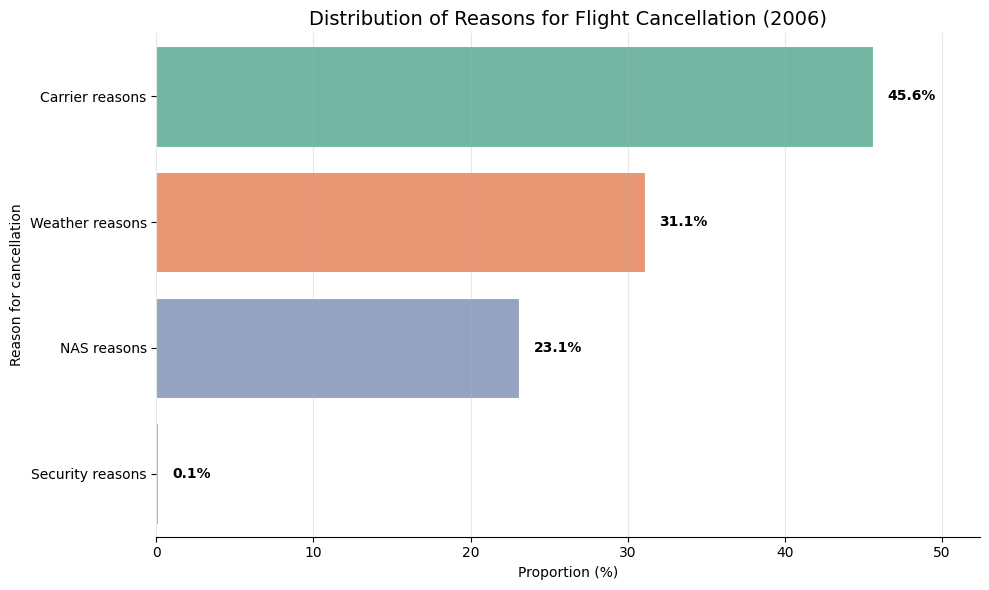

In [18]:
reason_dist = cancel_df['CancelReason'].value_counts(normalize=True).mul(100).round(1)
#Visualization
plt.figure(figsize=(10,6))
sns.barplot(
    x=reason_dist.values,
    y=reason_dist.index,
    palette=sns.color_palette("Set2", n_colors=len(reason_dist)),
    edgecolor='w',
    linewidth=0.8
)

plt.title('Distribution of Reasons for Flight Cancellation (2006)', fontsize=14)
plt.xlabel('Proportion (%)')
plt.ylabel('Reason for cancellation')
plt.grid(axis='x', alpha=0.3)
max_value = reason_dist.max()
for i, v in enumerate(reason_dist):
    offset = max_value * 0.02
    plt.text(v + offset, 
            i, 
            f"{v}%", 
            va='center', 
            color='black',
            fontsize=10,
            fontweight='semibold')

plt.xlim(0, max_value * 1.15)
sns.despine(left=True)
plt.tight_layout()
plt.show()

## Flight Cancellations by Airline

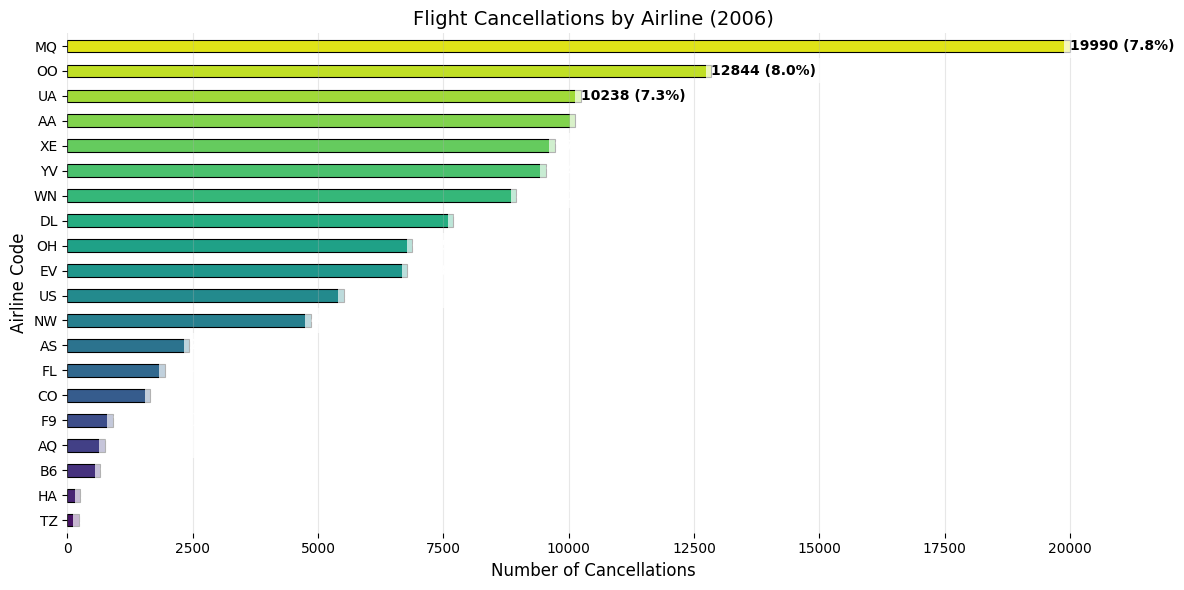

In [19]:
#Analyzing airline relationships
carrier_cancel = cancel_df.groupby('uniquecarrier', observed=True).size()
carrier_percent = carrier_cancel / len(cancel_df) * 100
#Visualization
plt.figure(figsize=(12,6))
sorted_carriers = carrier_cancel.sort_values()
colors = sns.color_palette("viridis", n_colors=len(sorted_carriers))
sorted_carriers.plot(
    kind='barh',
    color=colors,
    edgecolor='black',
    linewidth=0.8
)

plt.title('Flight Cancellations by Airline (2006)', fontsize=14)
plt.xlabel('Number of Cancellations', fontsize=12)
plt.ylabel('Airline Code', fontsize=12)
plt.grid(axis='x', alpha=0.3)
for i, (v, pct) in enumerate(zip(sorted_carriers, carrier_percent)):
    label_text = f"{v} ({pct:.1f}%)"
    text_color = 'black' if colors[i][0] > 0.6 else 'white'
    plt.text(
        v + 0.5, 
        i, 
        label_text,
        va='center',
        color=text_color,
        fontsize=10,
        fontweight='semibold',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none') 
    )
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

## TOP10 cancellations at departure airports

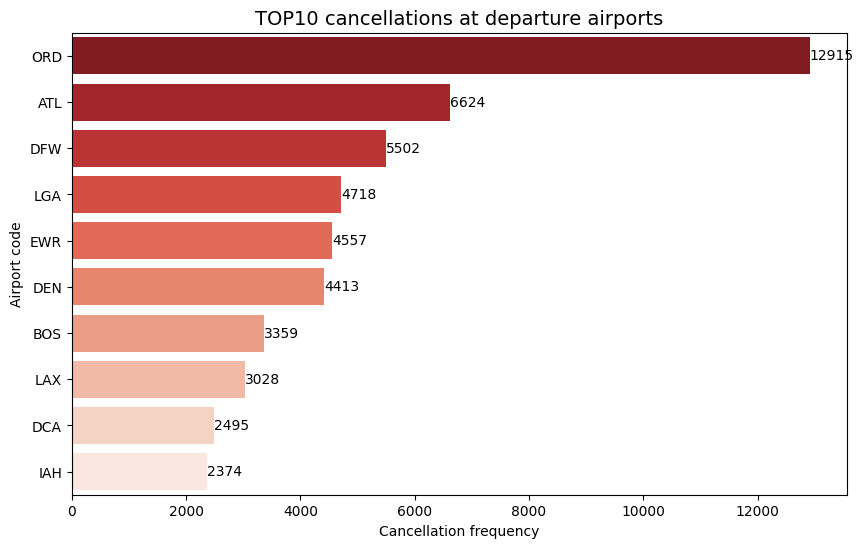

In [20]:
#Analyze airport association (departure point)
top_origin = cancel_df['origin'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_origin.values, y=top_origin.index, palette="Reds_r")
plt.title('TOP10 cancellations at departure airports', fontsize=14)
plt.xlabel('Cancellation frequency')
plt.ylabel('Airport code')
for i, v in enumerate(top_origin):
    plt.text(v+0.5, i, str(v), va='center')
plt.show()

## Monthly trend of flight cancellations

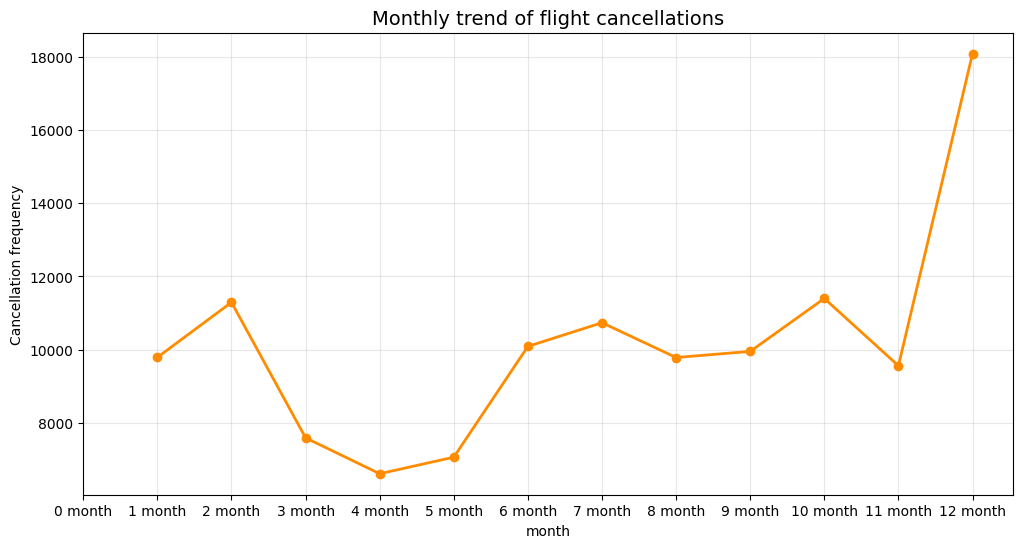

In [21]:
#Time cycle analysis
month_order = [f'{m} month' for m in range(0,13)]
season_map = {
    1: 'Winter', 2: 'Winter', 3: 'Spring',
    4: 'Spring', 5: 'Spring', 6: 'Summer',
    7: 'Summer', 8: 'Summer', 9: 'Fall',
    10: 'Fall', 11: 'Fall', 12: 'Winter'
}
#Monthly Analysis
plt.figure(figsize=(12,6))
cancel_df['month'].value_counts().reindex(range(1,13)).plot(
    kind='line', 
    marker='o', 
    color='darkorange',
    linewidth=2
)
plt.xticks(range(13), month_order)
plt.title('Monthly trend of flight cancellations', fontsize=14)
plt.ylabel('Cancellation frequency')
plt.grid(alpha=0.3)
plt.show()

## Seasonal distribution of flight cancellations

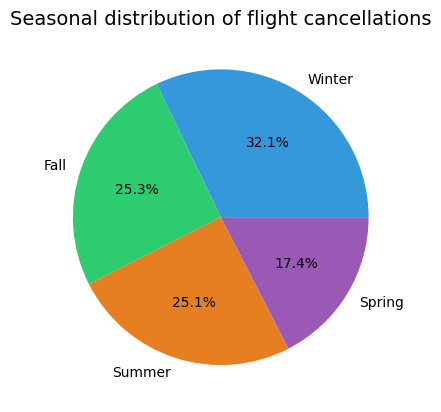

In [22]:
#Seasonal analysis
season_cancel = cancel_df['month'].map(season_map).value_counts()
plt.pie(season_cancel, 
        labels=season_cancel.index,
        autopct='%1.1f%%',
        colors=['#3498db', '#2ecc71', '#e67e22', '#9b59b6'])
plt.title('Seasonal distribution of flight cancellations', fontsize=14)
plt.show()

## Analysis Summary

In [23]:
print("\nStatistics of cancellation reasons:")
print(reason_dist.to_string())
print("\nAirline cancellations:")
print(carrier_cancel.sort_values(ascending=False).head(5).to_string())
print("\nCancellation ranking by departure airport:")
print(top_origin.to_string())


Statistics of cancellation reasons:
CancelReason
Carrier reasons     45.6
Weather reasons     31.1
NAS reasons         23.1
Security reasons     0.1

Airline cancellations:
uniquecarrier
MQ    19990
OO    12844
UA    10238
AA    10127
XE     9716

Cancellation ranking by departure airport:
origin
ORD    12915
ATL     6624
DFW     5502
LGA     4718
EWR     4557
DEN     4413
BOS     3359
LAX     3028
DCA     2495
IAH     2374


# 4.Problematic Routes

In [24]:
conn = hive.Connection(host="127.0.0.1",
                       port=10000,
                       username="maria_dev",
                       database="default")
query4 = """
SELECT 
    origin, dest, uniquecarrier, flightnum,
    arrdelay, cancelled, cancellationcode,
    carrierdelay, weatherdelay, nasdelay,
    securitydelay, lateaircraftdelay
FROM airline_2006
WHERE year=2006
"""

pro_df = pd.read_sql(query4, conn)
conn.close()
pro_df.head()

,origin,dest,uniquecarrier,flightnum,arrdelay,cancelled,cancellationcode,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay
0,ATL,PHX,US,343,6.0,0,,0,0,0,0,0
1,ATL,PHX,US,613,-5.0,0,,0,0,0,0,0
2,ATL,PHX,US,617,-23.0,0,,0,0,0,0,0
3,AUS,PHX,US,300,-8.0,0,,0,0,0,0,0
4,AUS,PHX,US,765,0.0,0,,0,0,0,0,0


In [25]:
delay_cols = ['carrierdelay','weatherdelay','nasdelay','securitydelay','lateaircraftdelay']
pro_df[delay_cols] = pro_df[delay_cols].fillna(0).astype(int)
pro_df['uniquecarrier'] = pro_df['uniquecarrier'].astype('category')

In [26]:
metrics = {
    'total_flights': ('flightnum', 'count'),
    'avg_delay': ('arrdelay', 'mean'),
    'delay_rate': ('arrdelay', lambda x: (x > 15).mean()),
    'cancellation_rate': ('cancelled', 'mean'),
    'carrier_delay_ratio': ('carrierdelay', lambda x: (x > 0).mean())
}

In [27]:
#Analysis by route
route_stats = pro_df.groupby(['origin', 'dest']).agg(**metrics)
problem_routes = route_stats[
    (route_stats['delay_rate'] > 0.3) |
    (route_stats['cancellation_rate'] > 0.05)
].sort_values('delay_rate', ascending=False)

In [28]:
#Analysis by airline
carrier_stats = pro_df.groupby('uniquecarrier').agg(**metrics)
problem_carriers = carrier_stats[
    (carrier_stats['delay_rate'] > 0.25) |
    (carrier_stats['cancellation_rate'] > 0.03)
]

In [29]:
#Analyze by flight number
flight_stats = pro_df.groupby(['uniquecarrier', 'flightnum']).agg(**metrics)
problem_flights = flight_stats[
    (flight_stats['total_flights'] > 10) &
    (flight_stats['delay_rate'] > 0.4)
]

## Analysis of the top 3 problematic routes

In [30]:
#Analysis of the top 3 problematic routes
route_analysis = []
for idx in problem_routes.head(3).index:
    origin, dest = idx
    subset = pro_df[(pro_df['origin'] == origin) & (pro_df['dest'] == dest)]
    
    delay_dist = subset[delay_cols].mean().to_dict()
    cancel_reason = subset['cancellationcode'].value_counts(normalize=True).index[0]
    
    route_analysis.append({
        'route': f"{origin}-{dest}",
        'main_delay_cause': max(delay_dist, key=delay_dist.get),
        'main_cancel_cause': cancel_reason,
        'avg_delay': subset['arrdelay'].mean(),
        'weather_impact': subset['weatherdelay'].mean()
    })

route_causes = pd.DataFrame(route_analysis)
route_causes

,route,main_delay_cause,main_cancel_cause,avg_delay,weather_impact
0,ABE-LGA,nasdelay,,83.0,0.0
1,DTW-CID,weatherdelay,,710.0,710.0
2,SRQ-BDL,carrierdelay,,79.0,0.0


## Analysis of the Delay Rates of the Top Problematic Routes

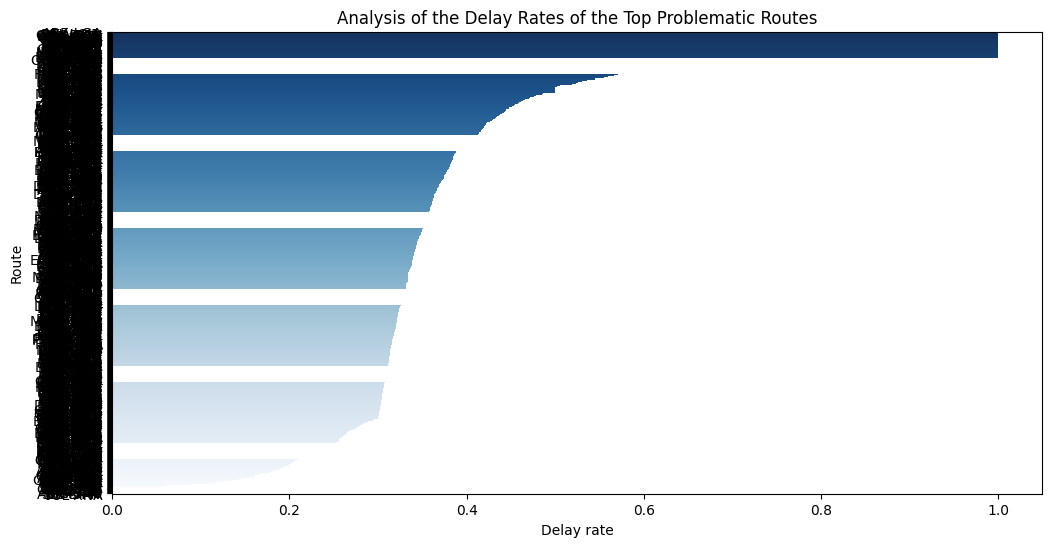

In [31]:
plt.figure(figsize=(12,6))
sns.barplot(
    x='delay_rate',
    y=problem_routes.index.map(lambda x: f"{x[0]}-{x[1]}"),
    data=problem_routes.reset_index(),
    palette='Blues_r'
)
plt.title('Analysis of the Delay Rates of the Top Problematic Routes')
plt.xlabel('Delay rate')
plt.ylabel('Route')
plt.show()

## Analyzing Problem Airlines

In [32]:
#Analyzing Problem Airlines
carrier_causes = []
for carrier in problem_carriers.index:
    subset = pro_df[pro_df['uniquecarrier'] == carrier]
    maint_ratio = subset['carrierdelay'].sum() / subset['arrdelay'].sum()
    
    carrier_causes.append({
        'carrier': carrier,
        'maintenance_ratio': maint_ratio,
    })

carrier_causes = pd.DataFrame(carrier_causes)
carrier_causes

,carrier,maintenance_ratio
0,B6,0.237860
1,EV,0.503370
2,MQ,0.319680
3,TZ,0.252344
4,YV,0.529942


## Decomposition of the causes of delays on major routes

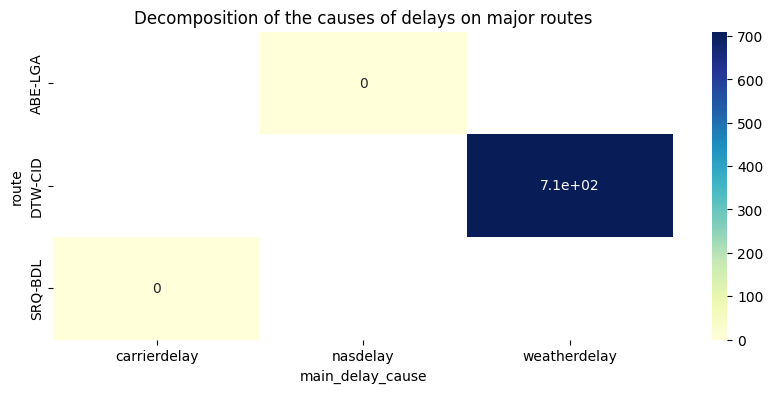

In [33]:
plt.figure(figsize=(10,4))
sns.heatmap(
    pd.pivot_table(
        route_causes,
        index='route',
        columns='main_delay_cause',
        values='weather_impact'
    ),
    annot=True,
    cmap='YlGnBu'
)
plt.title('Decomposition of the causes of delays on major routes')
plt.show()

## Analysis Summary

In [34]:
print("Analysis Summary:")
print(f"1. Worst route：{route_causes.iloc[0]['route']}")
print(f"   - Average delay：{route_causes.iloc[0]['avg_delay']:.1f} min")
print(f"   - Main reasons for delay：{route_causes.iloc[0]['main_delay_cause']}")
print(f"   - Weather influence：{route_causes.iloc[0]['weather_impact']:.1%}")

print(f"\n2. The worst airline：{carrier_causes.iloc[0]['carrier']}")
print(f"   - Proportion of maintenance issues：{carrier_causes.iloc[0]['maintenance_ratio']:.1%}")

Analysis Summary:
1. Worst route：ABE-LGA
   - Average delay：83.0 min
   - Main reasons for delay：nasdelay
   - Weather influence：0.0%

2. The worst airline：B6
   - Proportion of maintenance issues：23.8%
